# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Linear multidimensional regression

## I a) - Loading the data

In [2]:
data = pd.read_csv('data/linear_multi.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## I b) - Problem definition

We can define our MSE cost function $J(\mathbf{\theta})$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) = \frac{1}{2n} \sum_{i=1}^n (Y_i - \mathbf{X_i} \mathbf{\theta})^2
= \frac{1}{2 n} \| \mathbf{Y} - \mathbf{X} \mathbf{\theta} \|_2^2,
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla_{\mathbf{\theta}} J$:
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \mathbf{X_i}\mathbf{\theta})
$$
$$
\nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \mathbf{X}\mathbf{\theta})
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\mathbf{\theta}} J(\mathbf{X}, \mathbf{Y})
$$

It is common to decay the learning rate linearly until iteration $\tau$:
$$
\eta_t = (1-\alpha)\eta_0 + \alpha \eta_\tau
$$
with $\alpha = \frac{t}{\tau}$, and usually here we are going to take $\tau \approx 200$ and $\eta_\tau = \frac{\eta_0}{100}$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \mathbf{X}\mathbf{\theta}
$$

It is also common to add regularization to the loss.

MSE loss with L1 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mid\mathbf{\theta}_i\mid
$$
MSE loss with L2 penalty term:
$$
J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta})_{pen} = J(\mathbf{X}, \mathbf{Y}; \mathbf{\theta}) + \gamma \sum_{i=1}^n \mathbf{\theta}_i^2
$$

- **You are asked, wherever there are TODO expressions, to change the default expression by the right one**
- **Most expressions you are asked to implement can be found in the introduction above**

In [3]:
class LinearRegressor():
    def __init__(self, X, Y, penalization=None):
        p = X.shape[1]
        self.theta = np.random.normal(0, 1, p).reshape((p, 1))
        self.grad_theta = None
        self.training_losses_history = []
        self.validation_losses_history = []
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.penalization = penalization
        # Gamma here initialized to None, set to actual value in fit function
        self.gamma = None
        
    def split_train_validation(self, X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Must return the linear prediction given X
    def predict(self, X):
        return np.dot(X, self.theta) #(n,p)*(p,1)=(n,1)
    
    # Must return the gradient, penalized or not, of the given loss
    def compute_grad(self, X, Y, loss='MSE'):
        """Least-squares gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'MSE':
            # Here define the gradient of the given MSE loss
            # TODO:
            error = Y - self.predict(X)
            grad = (-1/n)*np.dot(X.T,error) #(p,n)*(n,1)=(p,1)
            if self.penalization == 'l2':
                # Here add to your current gradient the gradient of the l2 penalization term
                # TODO:
                grad += self.gamma*np.sum(2*self.theta)
            if self.penalization == 'l1':
                # Here add to your current gradient the gradient of the l1 penalization term
                # TODO:
                grad += self.gamma*np.sum(np.sign(self.theta))
        else:
            raise NotImplementedError
        return grad
    
    # Call the gradient computation function with the used loss and proceed to a gradient descent step
    # Use the parameter step as learning rate (êta_t in above gradient descent formula)
    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='MSE')
        # TODO:
        self.theta = self.theta - step*self.grad_theta
        
    # Must return the given loss, penalized or not, for Y_true and Y_pred as inputs
    def loss(self, Y_true, Y_pred, loss='MSE'):
        """Least-squares loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'MSE':
            # TODO:
            a = (1/(2*n))
            sse = np.sum(np.square(Y_true - Y_pred))
            loss = a*sse
            if self.penalization == 'l2':
                # Reminder: l2 penalization is the sum of the square parameters
                # TODO:
                loss += self.gamma*np.sum(np.square(self.theta))
            elif self.penalization == 'l1':
                # Reminder: l1 penalization is the sum of the absolute parameters
                # TODO:
                loss += self.gamma*np.sum(np.absolute(self.theta))
        else:
            raise NotImplementedError
        return loss
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
    
    # Step decay strategy, the idea is to have a step value that fluctuates with k until the tau value
    # Return the step value for iteration k
    def apply_step_decay(self, initial_step, k, tau=250):
        # Use formula in introduction
        # N.B.: êta_0 = initial_step
        # TODO:
        if(k<tau):
            alpha = k/tau
        else:
            alpha = 1
        eta_tau = initial_step/100
        new_step = (1-alpha)*initial_step + alpha* eta_tau
        return new_step
        
    def fit(self, initial_step=1e-1, min_iterations=50, max_iterations=5000, gamma=1e-3, 
            early_stopping=True, early_stopping_delta=1e-3, early_stopping_lookbehind=50, 
            step_decay=True, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        step = initial_step
        self.gamma = gamma
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.step_gradient_descent(step, self.X_tr, self.Y_tr)
            if step_decay:
                step = self.apply_step_decay(initial_step, iteration_number)
            training_loss = self.loss(self.Y_tr, self.predict(self.X_tr))
            self.training_losses_history.append(training_loss)
            validation_loss = self.loss(self.Y_val, self.predict(self.X_val))
            self.validation_losses_history.append(validation_loss)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t validation loss: {2:.4f}"
                print(msg.format(iteration_number, training_loss, validation_loss))
            if cpt_patience >= early_stopping_lookbehind:
                break

    def plot_loss_history(self):
        plt.figure(figsize=(12, 8))
        if not np.any(linear_regressor.training_losses_history):
            return None
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("MSE loss", fontsize=15)
        if not self.penalization:
            title = "MSE loss evolution during training, no penalization"
        else:
            title = "MSE loss evolution during training, penalization {}"
            title = title.format(self.penalization)
        plt.title(title, fontsize=20)
        plt.show()
    
    def plot_parameters(self, title=None):
        plt.figure(figsize=(6, 4))
        plt.scatter(range(len(self.theta)), self.theta)
        plt.xlabel("parameter dimension", fontsize=15)
        plt.ylabel("value", fontsize=15)
        if title is None:
            if not self.penalization:
                plt.title("Scatter plot of the learned parameters, no penalization", fontsize=15)
            else:
                plt.title(
                    "Scatter plot of the learned parameters, penalization {}".format(self.penalization), fontsize=15
                )
        else:
                plt.title(title)
        plt.show()

In [4]:
linear_regressor = LinearRegressor(X, Y)
ridge_linear_regressor = LinearRegressor(X, Y, penalization='l2')
lasso_linear_regressor = LinearRegressor(X, Y, penalization='l1')

linear_regressor.fit(verbose=True)
ridge_linear_regressor.fit(gamma=5e-2, verbose=True, step_decay=True)
lasso_linear_regressor.fit(gamma=5e-2, verbose=True, step_decay=True)

iteration number: 1	 training loss: 8735.5249	 validation loss: 9026.2696
iteration number: 2	 training loss: 7031.5608	 validation loss: 7286.1815
iteration number: 3	 training loss: 5673.6501	 validation loss: 5894.4954
iteration number: 4	 training loss: 4589.6749	 validation loss: 4779.6907
iteration number: 5	 training loss: 3722.9123	 validation loss: 3885.2866
iteration number: 6	 training loss: 3028.6735	 validation loss: 3166.6059
iteration number: 7	 training loss: 2471.6921	 validation loss: 2588.2508
iteration number: 8	 training loss: 2024.0918	 validation loss: 2122.1298
iteration number: 9	 training loss: 1663.8012	 validation loss: 1745.9145
iteration number: 10	 training loss: 1373.3167	 validation loss: 1441.8287
iteration number: 11	 training loss: 1138.7345	 validation loss: 1195.6985
iteration number: 12	 training loss: 948.9924	 validation loss: 996.2045
iteration number: 13	 training loss: 795.2748	 validation loss: 834.2930
iteration number: 14	 training loss: 6

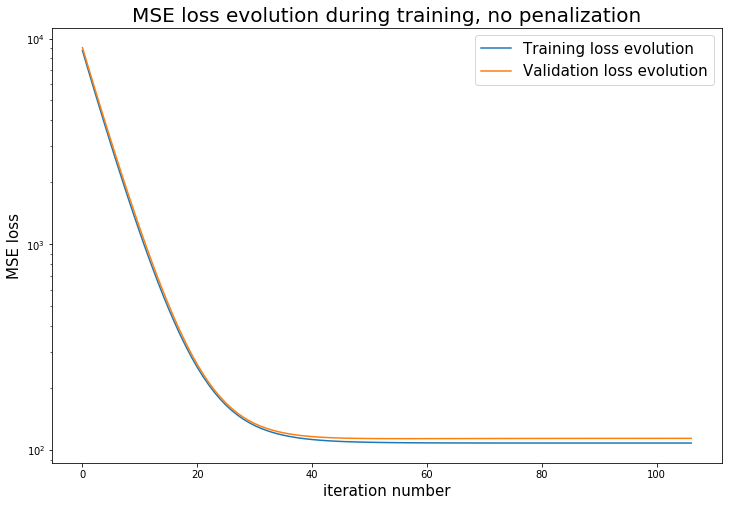

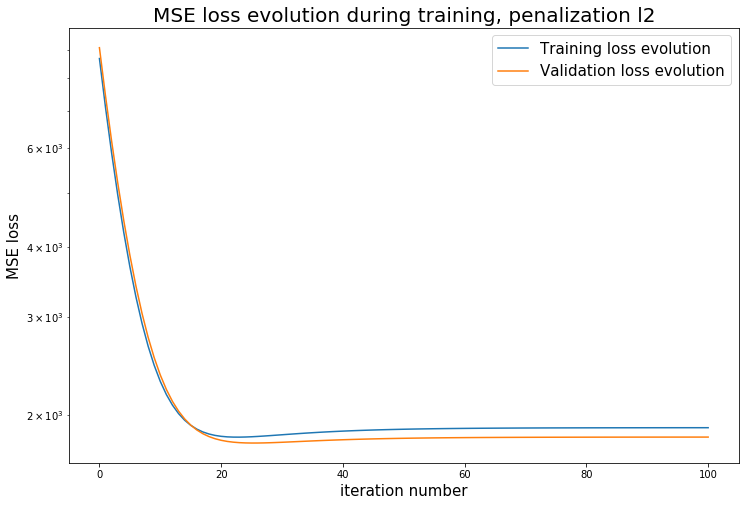

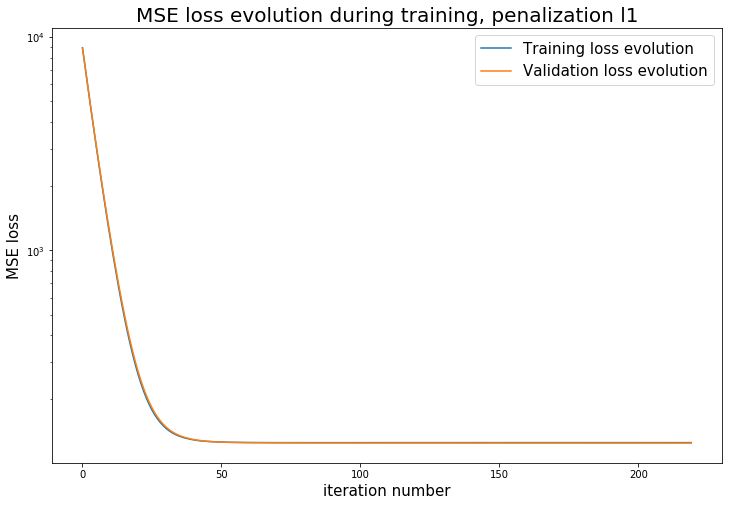

In [5]:
linear_regressor.plot_loss_history()
ridge_linear_regressor.plot_loss_history()
lasso_linear_regressor.plot_loss_history()

## Questions:
#### - What are l1 and l2 penalization strategies useful for? Did you achieve to improve your model's performance with them? Try different penalization values.

Avoid overfit  
Yes we achieve convergence quicker with l2 and l1 than without penalization.  
1e-5: Converge faster
5e-2: 
1e-1: 

#### - Consider the parameters plot. What could you conclude about the features information?
Nothing

# II - Non linear unidimensional regression

## II a) - Loading the data

In [6]:
data = pd.read_csv('data/non_linear.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
X, Y = X.reshape((Y.shape[0], 1)), Y.reshape((Y.shape[0], 1))

## II b) - Visualizing the data

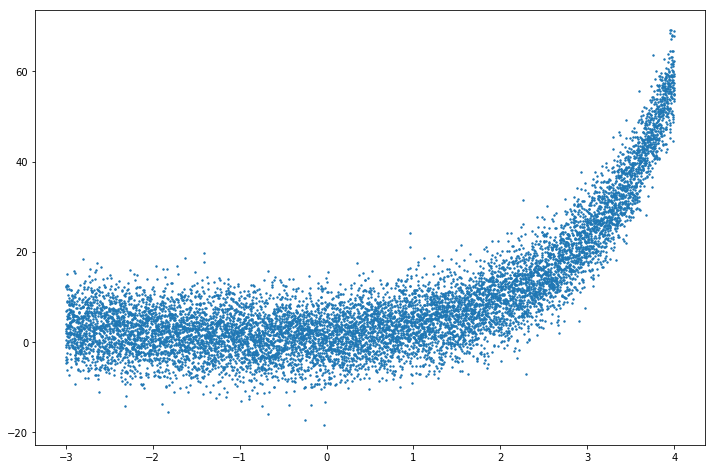

In [7]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, s=2)
plt.show()

- Notice the relation between $X$ and $Y$ is non linear
- You are supposed to map X to a new non linear representation more suited to the type of dependance between $X$ and $y$
- Using this new representation of $X$ use the linear regressor properties from the beginning to perform predictions

In [26]:
class PolynomialRegressor(LinearRegressor):
    def __init__(self, X, Y, degree=2, penalization=None):
        self.degree = degree
        self.initial_X_tr, self.initial_X_val, _, _ = self.split_train_validation(X, Y)
        X_transformed = self.non_linear_mapping(X)
        super(PolynomialRegressor, self).__init__(X_transformed, Y, penalization)

    def split_train_validation(self, X, Y, test_size=0.25, seed=True):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val

    # Must return a new features matrix based on a polynomial transformation
    def non_linear_mapping(self, X):
        # TODO:
        # Here do the mapping 
        new_X = np.ones(X.shape)
        for d in range(self.degree):
            new_row = np.power(X,d+1)
            new_X = np.concatenate((new_X,new_row),axis=1)
        return new_X
    
    def predict(self, X, apply_features_transformation=False):
        if apply_features_transformation:
            X_transformed = self.non_linear_mapping(X)
            return super(PolynomialRegressor, self).predict(X_transformed)
        else:
            return super(PolynomialRegressor, self).predict(X)
        
    def plot_prediction(self):
        assert self.initial_X_val.shape[1] == 1, "Too high dimensional design matrix to be plotted!"
        plt.figure(figsize=(12, 8))
        plt.scatter(self.initial_X_val, self.Y_val, s=5)
        plt.scatter(
            self.initial_X_val, self.predict(self.initial_X_val, apply_features_transformation=True), 
            color='red', s=5
        )
        plt.title("Prediction with polynomial regressor, degree={}".format(self.degree), fontsize=15)
        plt.show()

In [60]:
polynomial_regressor = PolynomialRegressor(X, Y, degree=3)
polynomial_regressor.fit(initial_step=1e-3, max_iterations=500, verbose=True)

iteration number: 1	 training loss: 429.3503	 validation loss: 446.7651
iteration number: 2	 training loss: 184.1064	 validation loss: 193.0991
iteration number: 3	 training loss: 94.4453	 validation loss: 99.6491
iteration number: 4	 training loss: 61.0837	 validation loss: 64.4630
iteration number: 5	 training loss: 48.2177	 validation loss: 50.6584
iteration number: 6	 training loss: 42.8678	 validation loss: 44.7958
iteration number: 7	 training loss: 40.3037	 validation loss: 41.9367
iteration number: 8	 training loss: 38.7921	 validation loss: 40.2468
iteration number: 9	 training loss: 37.6937	 validation loss: 39.0355
iteration number: 10	 training loss: 36.7710	 validation loss: 38.0376
iteration number: 11	 training loss: 35.9348	 validation loss: 37.1484
iteration number: 12	 training loss: 35.1507	 validation loss: 36.3246
iteration number: 13	 training loss: 34.4051	 validation loss: 35.5474
iteration number: 14	 training loss: 33.6920	 validation loss: 34.8076
iteration n

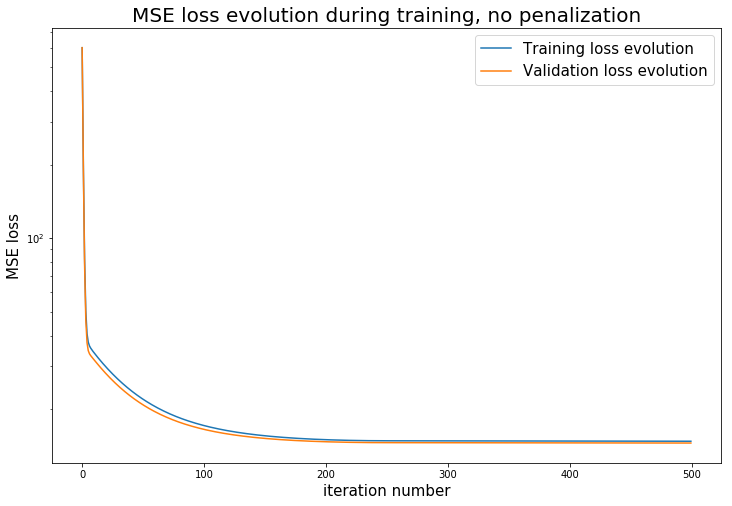

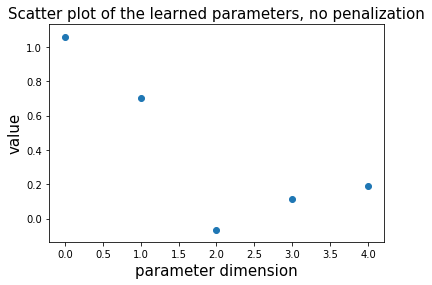

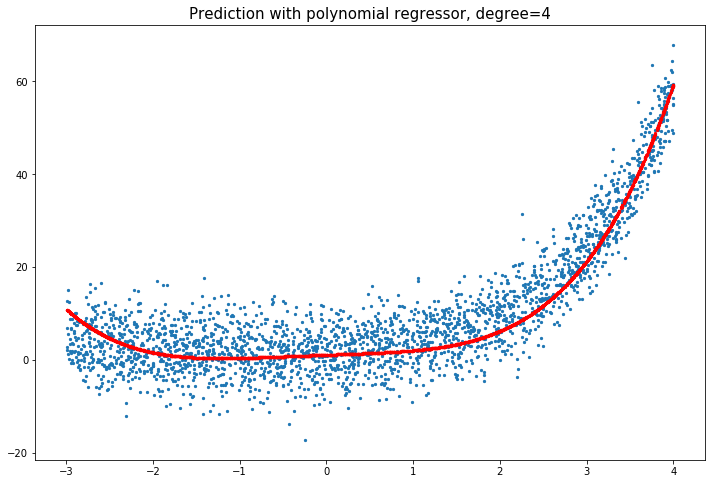

In [57]:
polynomial_regressor.plot_loss_history()
polynomial_regressor.plot_parameters()
polynomial_regressor.plot_prediction()

## Questions:
#### - Did you succeed to fit the data using a non linear mapping transformation?  
Yes
#### - Try different degrees, which one leads you to the best validation error?
- LR = 1e-2 ,deg = 2 : 18.5
- LR = 1e-3 ,deg = 2 : 26.3306
- LR = 1e-2, deg = 3 : bocou
- LR = 1e-3, deg = 3 : 13.9433 
- LR = 1e-4, deg = 4 : 16

# III - Logistic regression

## III a) - Loading the data

In [ ]:
data = pd.read_csv('data/breast_cancer_classification.csv', header=None)
X, Y = data.values[:, :-1], data.values[:, -1]
Y = Y.reshape((Y.shape[0], 1))

## III b) - Problem definition

Using the sigmoid function $\sigma(x)$ defined as:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

We can define our binary cross-entropy cost function $J(\theta)$ as follows:
$$
J(\mathbf{X}, \mathbf{Y}; \theta) = -\frac{1}{n} \sum_{i=1}^n Y_i \log \sigma(\mathbf{X_i}\mathbf{\theta}) + (1 - Y_i) \log (1 - \sigma(\mathbf{X_i} \mathbf{\theta})),
$$
with $\mathbf{Y} = [y_1 \cdots y_n]$, $\mathbf{X} = [\mathbf{x_1} \cdots \mathbf{x_n}]$,

$\mathbf{Y} \in \mathbb{R}^{n\times{1}}$ being the vector of labels, $\mathbf{X} \in \mathbb{R}^{n\times{p}}$ being the vector of features, $\mathbf{\theta} \in \mathbb{R}^{p\times{1}}$ being our parameters, and $n$ the number of samples.

Now we can calculate the gradient $\nabla J(\mathbf{\theta})$:
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y})^T = - \frac{1}{n} \sum_{i=1}^n \mathbf{X_i}(Y_i - \sigma(\mathbf{X_i}\mathbf{\theta}))
$$
$$
\nabla_{\theta} J(\mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \mathbf{X}^T(\mathbf{Y} - \sigma(\mathbf{X}\theta))
$$

It leads us to the gradient descend (GD) iterative algorithm:
$$
\mathbf{\theta}_{t+1} := \mathbf{\theta}_{t} - \eta_t \nabla_{\theta} J(\mathbf{X}, \mathbf{Y})
$$

And finally, our linear prediction $\mathbf{\hat{Y}}$ can be expressed as:
$$
\mathbf{\hat{Y}} = \sigma(\mathbf{X}\mathbf{\theta})
$$
- **no $\mathbf{\hat{Y}}_i$ should reach $0$ or $1$. If it does get rounded to $0$ or $1$, prevent that from happening by adding or removing EPSILON to $\mathbf{\hat{Y}}_i$**

In [ ]:
# Logistic Regression being a GLM, we can make an inheritance from the LinearRegressor class
class LogisticRegressor(LinearRegressor):
    def __init__(self, X, Y, penalization=None):
        super(LogisticRegressor, self).__init__(X, Y, penalization)
        self.X_tr, self.X_val = self.normalize(self.X_tr), self.normalize(self.X_val)
    
    # Return a normalized matrix with standardized features 0 mean 1 std
    def normalize(self, X):
        # TODO:
        return X
    
    # Return the model's accuracy on the validation dataset
    def accuracy_on_validation(self):
        # TODO:
        return 0.
        
    # Sigmoid function
    def sigmoid(self, X):
        # TODO:
        return X

    def predict(self, X, apply_normalization=False):
        if apply_normalization:
            X = self.normalize(X)
        return self.sigmoid(X.dot(self.theta))

    def compute_grad(self, X, Y, loss='CE'):
        """Binary cross-entropy gradient"""
        assert(X.shape[0] == Y.shape[0])
        n = X.shape[0]
        if loss == 'CE':
            # TODO:
            grad = np.zeros(self.theta.shape)
            if self.penalization == 'l2':
                # TODO:
                pass
            if self.penalization == 'l1':
                # TODO:
                pass
        else:
            raise NotImplementedError
        return grad

    def step_gradient_descent(self, step, X, Y):
        self.grad_theta = self.compute_grad(X, Y, loss='CE')
        # TODO:
        pass
    
    # Must return the given loss, penalized or not, for Y_true and Y_pred as inputs
    def loss(self, Y_true, Y_pred, loss='CE'):
        """Binary cross-entropy loss"""
        assert(Y_true.shape[0] == Y_pred.shape[0])
        n = Y_true.shape[0]
        if loss == 'CE':
            # TODO:
            loss = 0.
            if self.penalization == 'l2':
                # TODO:
                pass
            elif self.penalization == 'l1':
                # TODO:
                pass
        else:
            raise NotImplementedError
        return loss

In [ ]:
logistic_regressor = LogisticRegressor(X, Y)
logistic_regressor.fit(max_iterations=1000, initial_step=1e-1, step_decay=False)
logistic_regressor.plot_loss_history()

In [ ]:
print(logistic_regressor.accuracy_on_validation())

## Questions:
#### - Describe your normalization strategy and why it is important
#### - Why do we need a different loss function for a classification problem (why not MSE again?)
#### - Why is the normalization particulary relevant in this case? Compare the performances with and without it. Comment.